## 이미지만 보고 암살자 챔피언을 구분할 수 있을까?

자료 출처 : https://www.kaggle.com/datasets/ramananth/league-of-legends-champion-images  
참고 자료 : https://codetorial.net/tensorflow/classifying_the_cats_and_dogs.html

### 1. 데이터 불러오기

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np

In [2]:
# 기본 경로
base_dir = './data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 이미지 경로
train_assassin_dir = os.path.join(train_dir, 'assassin')
train_unassassin_dir = os.path.join(train_dir, 'unassassin')
print(train_assassin_dir)
print(train_unassassin_dir)

# 테스트에 사용되는 이미지 경로
validation_assassin_dir = os.path.join(validation_dir, 'assassin')
validation_unassassin_dir = os.path.join(validation_dir, 'unassassin')
print(validation_assassin_dir)
print(validation_unassassin_dir)

./data/train\assassin
./data/train\unassassin
./data/validation\assassin
./data/validation\unassassin


In [3]:
# 파일 이름 지정
train_assassin_fnames = os.listdir(train_assassin_dir)
train_unassassin_fnames = os.listdir(train_unassassin_dir)
validation_assassin_fnames = os.listdir(validation_assassin_dir)
validation_unassassin_fnames = os.listdir(validation_unassassin_dir)

# 5개만 확인
print(train_assassin_fnames[:5])
print(train_unassassin_fnames[:5])
print(validation_assassin_fnames)
print(validation_unassassin_fnames)

['s_01.jpg', 's_02.jpg', 's_03.jpg', 's_04.jpg', 's_05.jpg']
['b_01.jpg', 'b_02.jpg', 'b_03.jpg', 'b_04.jpg', 'b_05.jpg']
['test_01.PNG']
['test_02.PNG']


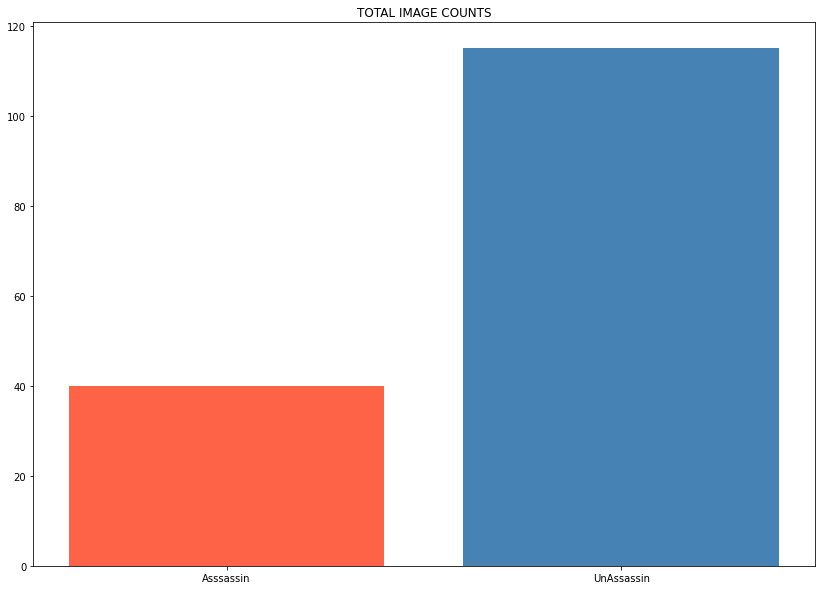

Total training Assassin images : 40
Total training UnAssassin images : 115


In [4]:
# 파일 개수 확인
plt.figure(figsize = (14,10))
plt.bar(x=['Asssassin', 'UnAssassin'], height = [len(os.listdir(train_assassin_dir)), len(os.listdir(train_unassassin_dir))], color = ['tomato', 'steelblue'])
plt.title("TOTAL IMAGE COUNTS")
plt.show()

print("Total training Assassin images :", len(os.listdir(train_assassin_dir)))
print("Total training UnAssassin images :", len(os.listdir(train_unassassin_dir)))

### 2. 데이터 확인

In [5]:
def showImage(type, num) :
    if type == 'Assassin' :
        img_path = train_assassin_dir
        img_path = os.path.join(img_path, train_assassin_fnames[num])
    elif type == 'UnAssassin' :
        img_path = train_unassassin_dir
        img_path = os.path.join(img_path, train_unassassin_fnames[num])
    try :
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(img_path)
        plt.show()
    except :
        print("잘못된 파일 경로입니다.")

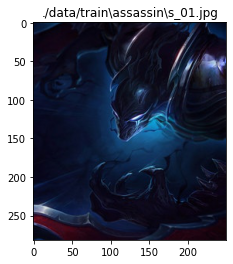

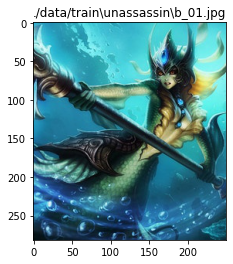

In [6]:
showImage('Assassin', 0)
showImage('UnAssassin', 0)

### 3. 전처리

In [7]:
# scaling
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [8]:
target_size_h, target_size_w = 64, 64

In [9]:
# genrator 생성
train_generator = train_datagen.flow_from_directory(train_dir,
batch_size=20,
class_mode='binary',
target_size=(target_size_h, target_size_w))

validation_generator = test_datagen.flow_from_directory(validation_dir,
batch_size=20,
class_mode='binary',
target_size=(target_size_h, target_size_w))

Found 155 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [10]:
# label 클래스 확인
train_generator.class_indices

{'assassin': 0, 'unassassin': 1}

In [11]:
# step 수 확인
len(train_generator), len(validation_generator)

(8, 1)

### 4. 모델 생성

In [12]:
# 모델 구성
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = (target_size_h, target_size_w, 3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [13]:
# EarlyStopping 적용
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, mode='auto')

In [14]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

c:\Users\USER\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 5. 모델 학습

In [15]:
history = model.fit(train_generator,
steps_per_epoch=len(train_generator),
epochs=15,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/15
8/8 [==============================] - 1s 55ms/step - loss: 1.0622 - accuracy: 0.7419 - val_loss: 0.9565 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 0s 35ms/step - loss: 0.6144 - accuracy: 0.7419 - val_loss: 0.9338 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 0s 36ms/step - loss: 0.6002 - accuracy: 0.7419 - val_loss: 0.7263 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 0s 39ms/step - loss: 0.5625 - accuracy: 0.7419 - val_loss: 0.7850 - val_accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 0s 39ms/step - loss: 0.6231 - accuracy: 0.7032 - val_loss: 0.7530 - val_accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 0s 37ms/step - loss: 0.5720 - accuracy: 0.7419 - val_loss: 0.7756 - val_accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 0s 36ms/step - loss: 0.5341 - accuracy: 0.7548 - val_loss: 1.0082 - val_accuracy: 0.5000
Epoch 8/15
8/8 [===========

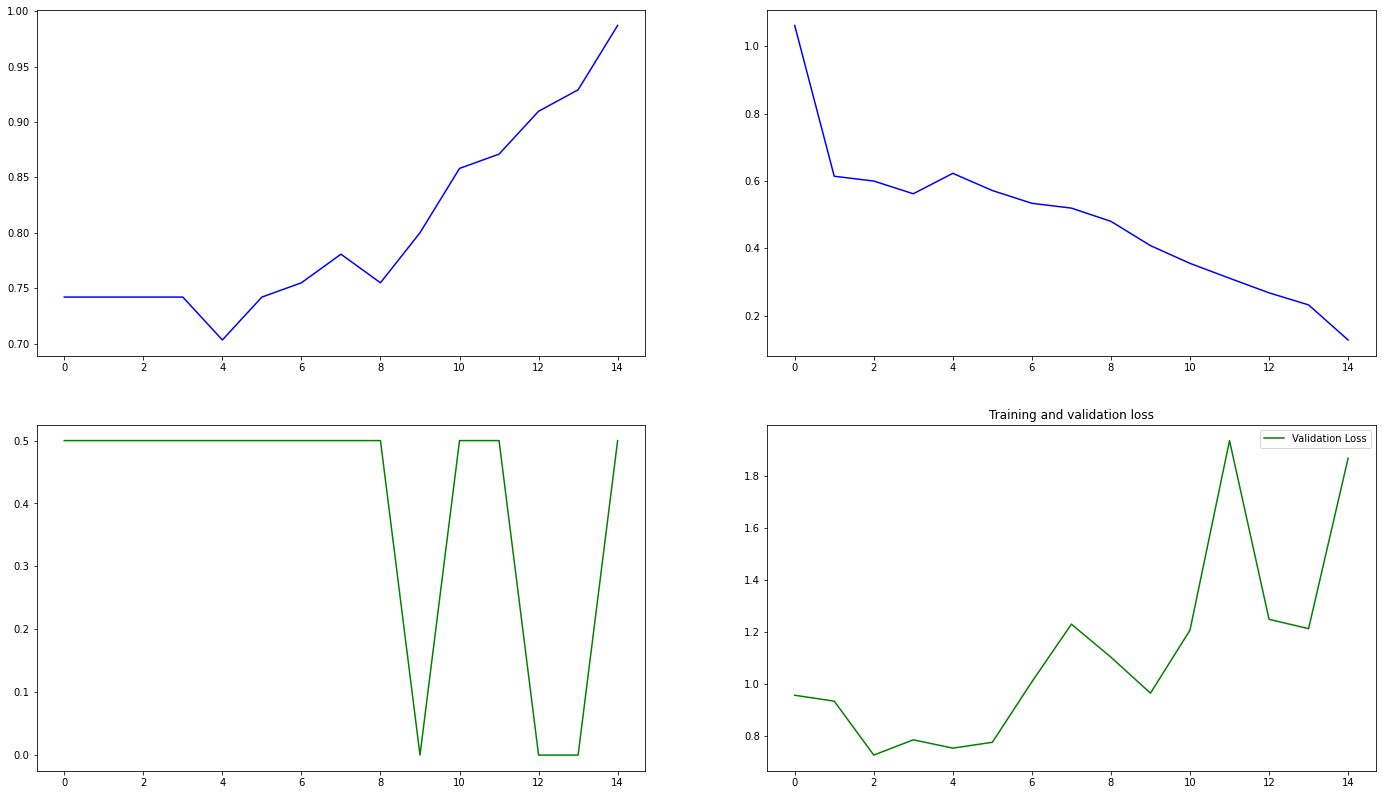

In [16]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(24,14))

plt.subplot(2,2,1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')


plt.subplot(2,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')

plt.subplot(2,2,3)
plt.plot(epochs, val_acc, 'g-', label='Validation accuracy')

plt.subplot(2,2,4)
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6. 모델 예측